In [1]:
library("deMULTIplex")
library("ggplot2")

Warning message:
“replacing previous import ‘lifecycle::last_warnings’ by ‘rlang::last_warnings’ when loading ‘tibble’”


In [2]:
## deMULTIplexing ##
setwd("/project/ABKlab/Natalia/sc-RNA-seq/single_TLS_project")

# Table 96h

In [3]:
bartable_96h <- readRDS("./files/bartable_96h.rds")

In [4]:
head(bartable_96h)
dim(bartable_96h)

,Bar1,Bar2,Bar3,Bar4,Bar5,Bar6,Bar7,Bar8,Bar9,Bar10,⋯,Bar17,Bar18,Bar19,Bar20,Bar21,Bar22,Bar23,Bar24,nUMI,nUMI_total
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
AAACCCAAGTGGAAAG,7,4,4,10,12,3,6,4,10,12,⋯,23,7,2,4,4,7,8,21,214,251
AAACCCACACTACTTT,10,4,9,9,9,3,9,0,6,13,⋯,10,3,4,13,1,7,3,4,173,215
AAACCCAGTAAGGCCA,2,6,4,7,4,9,11,3,10,14,⋯,13,10,5,3,2,7,37,0,211,247
AAACCCATCCACAGGC,31,9,5,5,3,6,8,3,11,15,⋯,17,7,6,4,7,6,6,5,231,286
AAACCCATCGGTCACG,12,8,8,5,482,6,3,3,5,14,⋯,8,10,3,3,28,6,3,2,679,798
AAACCCATCTGCATGA,6,7,10,4,3,7,3,7,14,16,⋯,11,4,43,2,4,8,4,6,242,295


[1] 9405   26

In [5]:
x <- bartable_96h
initial_cell_number <- nrow(bartable_96h)

## demultiplexing: classification

In [6]:
## Visualize barcode space
bar.tsne <- barTSNE(x[,1:24]) # number of barcodes and not columns !!
## Note: Exclude columns 97:98 (assuming 96 barcodes were used) which provide total barcode UMI counts for each cell. 

pdf("./outputs/MULTIseq/96h_bc.check.pdf")
for (i in 3:ncol(bar.tsne)) {
  g <- ggplot(bar.tsne, aes(x = TSNE1, y = TSNE2, color = bar.tsne[,i])) +
    geom_point() +
    scale_color_gradient(low = "black", high = "red") +
    ggtitle(colnames(bar.tsne)[i]) +
    theme(legend.position = "none") 
  print(g)
}
dev.off()


Loading required package: Rtsne



Performing PCA
Read the 9405 x 24 data matrix successfully!
OpenMP is working. 1 threads.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 3.96 seconds (sparsity = 0.014758)!
Learning embedding...
Iteration 50: error is 94.934703 (50 iterations in 1.78 seconds)
Iteration 100: error is 90.679339 (50 iterations in 1.80 seconds)
Iteration 150: error is 87.295037 (50 iterations in 1.57 seconds)
Iteration 200: error is 87.041712 (50 iterations in 1.55 seconds)
Iteration 250: error is 86.944249 (50 iterations in 1.54 seconds)
Iteration 300: error is 3.042258 (50 iterations in 1.47 seconds)
Iteration 350: error is 2.703091 (50 iterations in 1.40 seconds)
Iteration 400: error is 2.533070 (50 iterations in 1.37 seconds)
Iteration 450: error is 2.427649 (50 iterations in 1.36 seconds)
Iteration 500: error is 2.355692 (50 iterations in 1.37 seconds)
Iteration 550: error is 2.303701 (50 iterations in 1.37 seconds)
Iteration 60

png 
  2

[1] 0.01


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009



[1] 0.03
[1] 0.05
[1] 0.07
[1] 0.09
[1] 0.11
[1] 0.13
[1] 0.15
[1] 0.17
[1] 0.19
[1] 0.21
[1] 0.23
[1] 0.25
[1] 0.27
[1] 0.29
[1] 0.31
[1] 0.33
[1] 0.35
[1] 0.37
[1] 0.39
[1] 0.41
[1] 0.43
[1] 0.45
[1] 0.47
[1] 0.49
[1] 0.51
[1] 0.53
[1] 0.55
[1] 0.57
[1] 0.59
[1] 0.61
[1] 0.63
[1] 0.65
[1] 0.67
[1] 0.69
[1] 0.71
[1] 0.73
[1] 0.75
[1] 0.77
[1] 0.79
[1] 0.81
[1] 0.83
[1] 0.85
[1] 0.87
[1] 0.89
[1] 0.91
[1] 0.93
[1] 0.95
[1] 0.97
[1] 0.99


Loading required package: reshape2



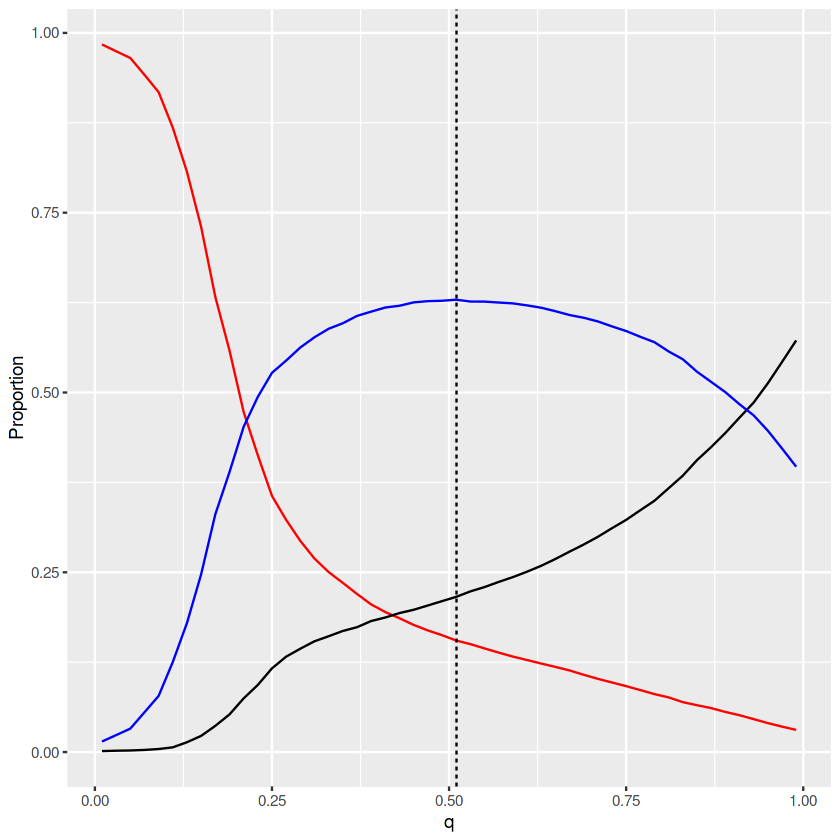

In [7]:
# Sample classification
## Round 1 -----------------------------------------------------------------------------------------------------
## Perform Quantile Sweep
bar.table.full <- x[,1:24]
good.bars <- paste("Bar",1:24,sep="")  # NOTE: In this hypothetical example, barcodes 91-96 were not detected
bar.table <- bar.table.full[, good.bars]  # Remove missing bars and summary columns
bar.table_sweep.list <- list()
n <- 0
for (q in seq(0.01, 0.99, by=0.02)) {
  print(q)
  n <- n + 1
  bar.table_sweep.list[[n]] <- classifyCells(bar.table, q=q)
  names(bar.table_sweep.list)[n] <- paste("q=",q,sep="")
}

## Identify ideal inter-maxima quantile to set barcode-specific thresholds
threshold.results1 <- findThresh(call.list=bar.table_sweep.list)
ggplot(data=threshold.results1$res, aes(x=q, y=Proportion, color=Subset)) + geom_line() + theme(legend.position = "none") +
  geom_vline(xintercept=threshold.results1$extrema, lty=2) + scale_color_manual(values=c("red","black","blue"))

## Finalize round 1 classifications, remove negative cells
round1.calls <- classifyCells(bar.table, q=findQ(threshold.results1$res, threshold.results1$extrema))
neg.cells <- names(round1.calls)[which(round1.calls == "Negative")]
bar.table <- bar.table[-which(rownames(bar.table) %in% neg.cells), ]


In [8]:
table(round1.calls)
length(round1.calls)

round1.calls
    Bar1    Bar10    Bar11    Bar12    Bar13    Bar14    Bar15    Bar16 
     337      259      274      266      278      198      276      363 
   Bar17    Bar18    Bar19     Bar2    Bar20    Bar21    Bar22    Bar23 
     290      165      203      227      213      185      219      273 
   Bar24     Bar3     Bar4     Bar5     Bar6     Bar7     Bar8     Bar9 
     298      184      203      286      215      165      212      327 
 Doublet Negative 
    1459     2030 

[1] 9405

In [9]:
## Round 2 -----------------------------------------------------------------------------------------------------
bar.table_sweep.list <- list()
n <- 0
for (q in seq(0.01, 0.99, by=0.02)) {
  print(q)
  n <- n + 1
  bar.table_sweep.list[[n]] <- classifyCells(bar.table, q=q)
  names(bar.table_sweep.list)[n] <- paste("q=",q,sep="")
}

threshold.results2 <- findThresh(call.list=bar.table_sweep.list)
round2.calls <- classifyCells(bar.table, q=findQ(threshold.results2$res, threshold.results2$extrema))
neg.cells <- c(neg.cells, names(round2.calls)[which(round2.calls == "Negative")])

[1] 0.01
[1] 0.03
[1] 0.05
[1] 0.07
[1] 0.09
[1] 0.11
[1] 0.13
[1] 0.15
[1] 0.17
[1] 0.19
[1] 0.21
[1] 0.23
[1] 0.25
[1] 0.27
[1] 0.29
[1] 0.31
[1] 0.33
[1] 0.35
[1] 0.37
[1] 0.39
[1] 0.41
[1] 0.43
[1] 0.45
[1] 0.47
[1] 0.49
[1] 0.51
[1] 0.53
[1] 0.55
[1] 0.57
[1] 0.59
[1] 0.61
[1] 0.63
[1] 0.65
[1] 0.67
[1] 0.69
[1] 0.71
[1] 0.73
[1] 0.75
[1] 0.77
[1] 0.79
[1] 0.81
[1] 0.83
[1] 0.85
[1] 0.87
[1] 0.89
[1] 0.91
[1] 0.93
[1] 0.95
[1] 0.97
[1] 0.99


In [10]:
length(neg.cells)

table(round2.calls)
length(round2.calls)

[1] 2069

round2.calls
    Bar1    Bar10    Bar11    Bar12    Bar13    Bar14    Bar15    Bar16 
     329      258      277      261      275      197      275      361 
   Bar17    Bar18    Bar19     Bar2    Bar20    Bar21    Bar22    Bar23 
     288      167      197      222      214      182      220      273 
   Bar24     Bar3     Bar4     Bar5     Bar6     Bar7     Bar8     Bar9 
     297      183      202      283      215      160      211      327 
 Doublet Negative 
    1462       39 

[1] 7375

In [11]:
## Round 3 -----------------------------------------------------------------------------------------------------
bar.table_sweep.list <- list()
n <- 0
for (q in seq(0.01, 0.99, by=0.02)) {
  print(q)
  n <- n + 1
  bar.table_sweep.list[[n]] <- classifyCells(bar.table, q=q)
  names(bar.table_sweep.list)[n] <- paste("q=",q,sep="")
}

threshold.results3 <- findThresh(call.list=bar.table_sweep.list)
round3.calls <- classifyCells(bar.table, q=findQ(threshold.results3$res, threshold.results3$extrema))
neg.cells <- c(neg.cells, names(round3.calls)[which(round3.calls == "Negative")])

[1] 0.01
[1] 0.03
[1] 0.05
[1] 0.07
[1] 0.09
[1] 0.11
[1] 0.13
[1] 0.15
[1] 0.17
[1] 0.19
[1] 0.21
[1] 0.23
[1] 0.25
[1] 0.27
[1] 0.29
[1] 0.31
[1] 0.33
[1] 0.35
[1] 0.37
[1] 0.39
[1] 0.41
[1] 0.43
[1] 0.45
[1] 0.47
[1] 0.49
[1] 0.51
[1] 0.53
[1] 0.55
[1] 0.57
[1] 0.59
[1] 0.61
[1] 0.63
[1] 0.65
[1] 0.67
[1] 0.69
[1] 0.71
[1] 0.73
[1] 0.75
[1] 0.77
[1] 0.79
[1] 0.81
[1] 0.83
[1] 0.85
[1] 0.87
[1] 0.89
[1] 0.91
[1] 0.93
[1] 0.95
[1] 0.97
[1] 0.99


In [12]:
length(neg.cells)

table(round3.calls)
length(round3.calls)

[1] 2108

round3.calls
    Bar1    Bar10    Bar11    Bar12    Bar13    Bar14    Bar15    Bar16 
     329      258      277      261      275      197      275      361 
   Bar17    Bar18    Bar19     Bar2    Bar20    Bar21    Bar22    Bar23 
     288      167      197      222      214      182      220      273 
   Bar24     Bar3     Bar4     Bar5     Bar6     Bar7     Bar8     Bar9 
     297      183      202      283      215      160      211      327 
 Doublet Negative 
    1462       39 

[1] 7375

In [13]:
## Repeat until all no negative cells remain (usually 3 rounds)...
final.calls <- c(round3.calls, rep("Negative",length(neg.cells)))
names(final.calls) <- c(names(round3.calls),neg.cells)

In [14]:
head(bar.table)
dim(bar.table)

,Bar1,Bar2,Bar3,Bar4,Bar5,Bar6,Bar7,Bar8,Bar9,Bar10,⋯,Bar15,Bar16,Bar17,Bar18,Bar19,Bar20,Bar21,Bar22,Bar23,Bar24
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
AAACCCAGTAAGGCCA,2,6,4,7,4,9,11,3,10,14,⋯,8,18,13,10,5,3,2,7,37,0
AAACCCATCGGTCACG,12,8,8,5,482,6,3,3,5,14,⋯,10,27,8,10,3,3,28,6,3,2
AAACCCATCTGCATGA,6,7,10,4,3,7,3,7,14,16,⋯,11,33,11,4,43,2,4,8,4,6
AAACGAAAGCCTATCA,224,1,3,38,8,4,3,6,14,16,⋯,9,16,17,10,4,3,3,6,6,9
AAACGAAAGGAAGAAC,5,2,5,2,6,3,2,3,9,7,⋯,8,19,8,441,3,5,1,11,2,2
AAACGAACAATACGAA,9,3,5,7,3,8,11,3,7,7,⋯,8,21,606,4,5,5,3,6,6,9


[1] 7375   24

In [15]:
## Visualize barcode space
bar.tsne <- barTSNE(bar.table[,1:24]) 
## Note: Exclude columns 97:98 (assuming 96 barcodes were used) which provide total barcode UMI counts for each cell. 

pdf("./outputs/MULTIseq/96h_bc.check_round3.pdf")
for (i in 3:ncol(bar.tsne)) {
  g <- ggplot(bar.tsne, aes(x = TSNE1, y = TSNE2, color = bar.tsne[,i])) +
    geom_point() +
    scale_color_gradient(low = "black", high = "red") +
    ggtitle(colnames(bar.tsne)[i]) +
    theme(legend.position = "none") 
  print(g)
}
dev.off()

Performing PCA
Read the 7375 x 24 data matrix successfully!
OpenMP is working. 1 threads.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 2.63 seconds (sparsity = 0.017792)!
Learning embedding...
Iteration 50: error is 92.352855 (50 iterations in 1.41 seconds)
Iteration 100: error is 80.921995 (50 iterations in 1.35 seconds)
Iteration 150: error is 75.008793 (50 iterations in 1.32 seconds)
Iteration 200: error is 72.702188 (50 iterations in 1.36 seconds)
Iteration 250: error is 71.472652 (50 iterations in 1.41 seconds)
Iteration 300: error is 2.493691 (50 iterations in 1.27 seconds)
Iteration 350: error is 2.175956 (50 iterations in 1.12 seconds)
Iteration 400: error is 2.015345 (50 iterations in 1.10 seconds)
Iteration 450: error is 1.915161 (50 iterations in 1.10 seconds)
Iteration 500: error is 1.847683 (50 iterations in 1.11 seconds)
Iteration 550: error is 1.799565 (50 iterations in 1.12 seconds)
Iteration 60

png 
  2

## Generation of barcode table

In [16]:
head(bar.table)
dim(bar.table)
bar.table$cell <- rownames(bar.table)

,Bar1,Bar2,Bar3,Bar4,Bar5,Bar6,Bar7,Bar8,Bar9,Bar10,⋯,Bar15,Bar16,Bar17,Bar18,Bar19,Bar20,Bar21,Bar22,Bar23,Bar24
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
AAACCCAGTAAGGCCA,2,6,4,7,4,9,11,3,10,14,⋯,8,18,13,10,5,3,2,7,37,0
AAACCCATCGGTCACG,12,8,8,5,482,6,3,3,5,14,⋯,10,27,8,10,3,3,28,6,3,2
AAACCCATCTGCATGA,6,7,10,4,3,7,3,7,14,16,⋯,11,33,11,4,43,2,4,8,4,6
AAACGAAAGCCTATCA,224,1,3,38,8,4,3,6,14,16,⋯,9,16,17,10,4,3,3,6,6,9
AAACGAAAGGAAGAAC,5,2,5,2,6,3,2,3,9,7,⋯,8,19,8,441,3,5,1,11,2,2
AAACGAACAATACGAA,9,3,5,7,3,8,11,3,7,7,⋯,8,21,606,4,5,5,3,6,6,9


[1] 7375   24

In [17]:
table(final.calls)
length(final.calls)

final.calls
    Bar1    Bar10    Bar11    Bar12    Bar13    Bar14    Bar15    Bar16 
     329      258      277      261      275      197      275      361 
   Bar17    Bar18    Bar19     Bar2    Bar20    Bar21    Bar22    Bar23 
     288      167      197      222      214      182      220      273 
   Bar24     Bar3     Bar4     Bar5     Bar6     Bar7     Bar8     Bar9 
     297      183      202      283      215      160      211      327 
 Doublet Negative 
    1462     2147 

[1] 9483

In [18]:
prueba <- as.matrix(final.calls)
prueba <- as.data.frame(prueba)
prueba$cell <- rownames(prueba)
table(prueba$V1)

prueba.merged <- merge (bar.table, prueba, by = "cell")
prueba.merged$V1 <- as.character(prueba.merged$V1)

barcode_assignment_96h <- prueba.merged
head(barcode_assignment_96h)
dim(barcode_assignment_96h)
table(barcode_assignment_96h$V1)


    Bar1    Bar10    Bar11    Bar12    Bar13    Bar14    Bar15    Bar16 
     329      258      277      261      275      197      275      361 
   Bar17    Bar18    Bar19     Bar2    Bar20    Bar21    Bar22    Bar23 
     288      167      197      222      214      182      220      273 
   Bar24     Bar3     Bar4     Bar5     Bar6     Bar7     Bar8     Bar9 
     297      183      202      283      215      160      211      327 
 Doublet Negative 
    1462     2147 

,cell,Bar1,Bar2,Bar3,Bar4,Bar5,Bar6,Bar7,Bar8,Bar9,⋯,Bar16,Bar17,Bar18,Bar19,Bar20,Bar21,Bar22,Bar23,Bar24,V1
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,AAACCCAGTAAGGCCA,2,6,4,7,4,9,11,3,10,⋯,18,13,10,5,3,2,7,37,0,Bar23
2,AAACCCATCGGTCACG,12,8,8,5,482,6,3,3,5,⋯,27,8,10,3,3,28,6,3,2,Doublet
3,AAACCCATCTGCATGA,6,7,10,4,3,7,3,7,14,⋯,33,11,4,43,2,4,8,4,6,Bar19
4,AAACGAAAGCCTATCA,224,1,3,38,8,4,3,6,14,⋯,16,17,10,4,3,3,6,6,9,Doublet
5,AAACGAAAGGAAGAAC,5,2,5,2,6,3,2,3,9,⋯,19,8,441,3,5,1,11,2,2,Bar18
6,AAACGAACAATACGAA,9,3,5,7,3,8,11,3,7,⋯,21,606,4,5,5,3,6,6,9,Bar17


[1] 7375   26


    Bar1    Bar10    Bar11    Bar12    Bar13    Bar14    Bar15    Bar16 
     329      258      277      261      275      197      275      361 
   Bar17    Bar18    Bar19     Bar2    Bar20    Bar21    Bar22    Bar23 
     288      167      197      222      214      182      220      273 
   Bar24     Bar3     Bar4     Bar5     Bar6     Bar7     Bar8     Bar9 
     297      183      202      283      215      160      211      327 
 Doublet Negative 
    1462       39 

## Generation of table of assignment for stacked barplot visualization

In [19]:
x <- data.frame(table(barcode_assignment_96h$V1))
x

Var1,Freq
<fct>,<int>
Bar1,329
Bar10,258
Bar11,277
Bar12,261
Bar13,275
Bar14,197
Bar15,275
Bar16,361
Bar17,288


In [20]:
bar <- sum(x$Freq[-(25:26)])
doublet <- x[x[1]=='Doublet',2]
negative <- x[x[1]=='Negative',2]
unassigned <- initial_cell_number - sum(bar, doublet, negative)
unassigned

[1] 2030

In [21]:
x <- data.frame(Number_cells= c(bar, doublet, negative, unassigned))
rownames(x) <- c("Barcode_assigned","Doublet","Negative", "Unassigned")
x$Category <- rownames(x)
x$Category <- factor(x$Category, levels = c("Unassigned","Negative","Doublet","Barcode_assigned"))
x$Sample <- "gast_96h"
head(x)

multiseq_assignment_96h <- x

,Number_cells,Category,Sample
,<int>,<fct>,<chr>
Barcode_assigned,5874,Barcode_assigned,gast_96h
Doublet,1462,Doublet,gast_96h
Negative,39,Negative,gast_96h
Unassigned,2030,Unassigned,gast_96h


In [22]:
sum(multiseq_assignment_96h$Number_cells)
initial_cell_number
sum(multiseq_assignment_96h$Number_cells) == initial_cell_number

[1] 9405

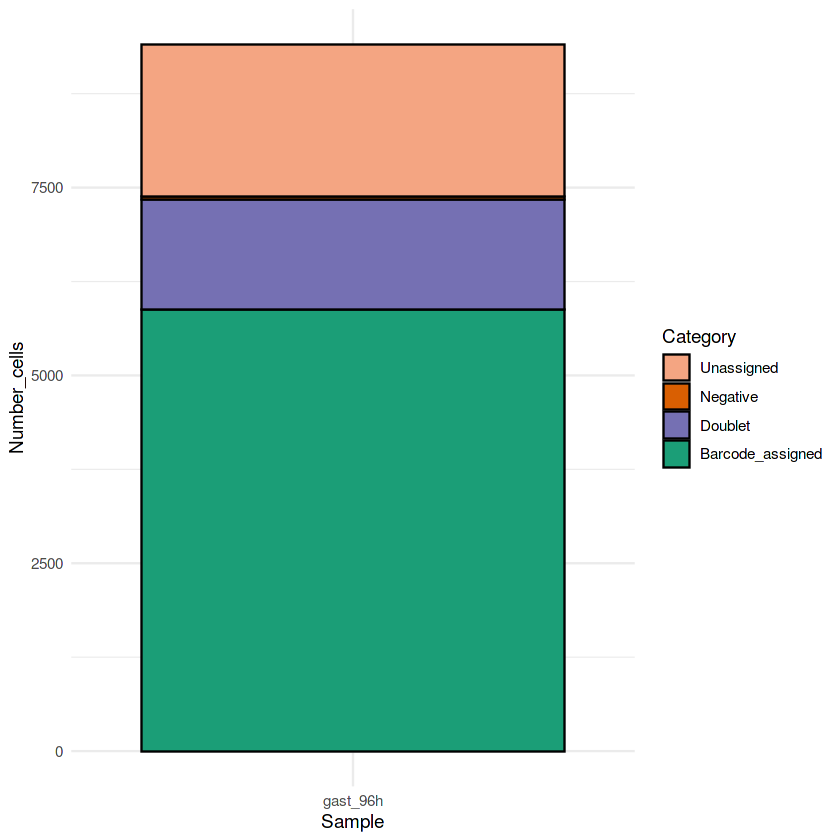

In [23]:
# Stacked
ggplot(x, aes(fill=Category, y=Number_cells, x=Sample)) + 
  geom_bar(position="stack", stat="identity", colour="black") +
  scale_fill_manual(values=c("#f4a582", "#d95f02", "#7570b3", "#1b9e77")) + 
  theme_minimal()

## Saving the files

In [24]:
# Save files
## 
saveRDS(barcode_assignment_96h, file = "./files/demultiplexing/barcode_assignment_96h.rds")
saveRDS(multiseq_assignment_96h, file = "./files/demultiplexing/multiseq_assignment_96h.rds")